In [1]:
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import gc
from PIL import Image
from torch.nn import functional as F
import warnings
warnings.filterwarnings('ignore')
from facenet_pytorch import InceptionResnetV1
from torchvision import transforms
from torchvision.transforms import v2
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from torchmetrics.regression import R2Score, PearsonCorrCoef, SpearmanCorrCoef
from collections import defaultdict
import pickle
import math
import warnings
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import torch.nn as nn
import os
import random
warnings.filterwarnings('ignore')
from PIL import Image
import re
import pickle

random_number = 1997         
random.seed(random_number)
os.environ['PYTHONHASHSEED'] = str(random_number)
np.random.seed(random_number)
torch.manual_seed(random_number)
torch.cuda.manual_seed(random_number)
torch.cuda.manual_seed_all(random_number)
torch.backends.cudnn.deterministic = True


face = pd.read_excel(r'C:\Users\tur74612\Desktop\Project\Data\face_with_text.xlsx')
mem_socres = pd.read_excel(r'C:\Users\tur74612\Desktop\Project\Data\memorability-scores.xlsx')
path = r'C:\Users\tur74612\Desktop\Project\Data\cropped_image'
face.text_description = face.text_description.apply(lambda x:  re.sub(r"[^a-zA-Z0-9\s.?]", " ", x)).apply(lambda x: re.sub('\s+', ' ', x))
img_files = os.listdir(path)
face = face[face.image_id.isin(img_files)]
face = face.reset_index(drop=True)
mem_socres = mem_socres.iloc[:,[0,6,7,8]]
mem_socres.columns = ['image_id','hr','far','thr']
face = face.merge(mem_socres, on='image_id', how='left' )

scaler = MinMaxScaler()

train_df,valid_df = train_test_split(face, test_size=0.2, random_state=random_number) 
test_df,valid_df = train_test_split(valid_df, test_size=0.5, random_state=random_number) 

train_df.memorable = scaler.fit_transform(train_df.memorable.values.reshape(-1,1))
valid_df.memorable = scaler.transform(valid_df.memorable.values.reshape(-1,1))
test_df.memorable = scaler.transform(test_df.memorable.values.reshape(-1,1))

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(15),
    transforms.ToTensor()])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()])


from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


class MyDataset(Dataset):

  def __init__(self, imgs , txts , target, train_prep, tokenizer, max_len):
    self.imgs = imgs
    self.txts = txts
    self.target = target
    self.train_prep = train_prep
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.imgs)
  
  def __getitem__(self, item):
    
    im = Image.open(path + '\\' + self.imgs[item])

    if self.train_prep:
       imgs = transform_train(im)
    else:
       imgs = transform_test(im)

    txts = str(self.txts[item])

    encoding = self.tokenizer.encode_plus(
      txts,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      truncation=True,
      return_tensors='pt',
    )

    target = self.target[item]

    return {
      'target': target.reshape(1,),
      'imgs_t': imgs,
      'txts': txts,
      'input_ids': encoding['input_ids'].squeeze(),
      'attention_mask': encoding['attention_mask'].squeeze(),
          }


def create_data_loader_train(X_v, X_t, Y, batch_size):

  ds = MyDataset(
    imgs = X_v,
    txts =X_t,
    target =Y,
    train_prep = True,
    tokenizer = tokenizer, max_len = 512
  )
  return DataLoader(
    ds,
    batch_size=batch_size
      , shuffle= True, generator=torch.Generator(device='cpu').manual_seed(random_number)
  )

def create_data_loader_test(X_v, X_t, Y, batch_size):

  ds = MyDataset(
    imgs = X_v,
    txts =X_t,
    target =Y,
    train_prep = False,
    tokenizer = tokenizer, max_len = 512
  )
  return DataLoader(
    ds,
    batch_size=batch_size
      , shuffle= False, generator=torch.Generator(device='cpu').manual_seed(random_number)
  )

train_data_loader = create_data_loader_train(train_df.image_id.values,train_df.text_description.values, train_df.thr.values, 64)

validation_data_loader = create_data_loader_test(valid_df.image_id.values,valid_df.text_description.values, valid_df.thr.values, len(valid_df))

test_data_loader = create_data_loader_test(test_df.image_id.values,test_df.text_description.values, test_df.thr.values, len(test_df))


class NeuronSpecificDropout(nn.Module):
    def __init__(self, p=0.5):
        super(NeuronSpecificDropout, self).__init__()
        self.p = p
        self.mask = None

    def forward(self, x):
        if self.training:
            if self.mask is None:
                self.mask = torch.bernoulli(torch.full_like(x, 1 - self.p))
            x = x * self.mask / (1 - self.p)
        else:
            x = x
        return x
    
    
###Senet From code from https://github.com/cydonia999/VGGFace2-pytorch/blob/master/models/senet.py
import torch.nn as nn
import math
import torch.nn.functional as F

__all__ = ['SENet', 'senet50']

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class SEModule(nn.Module):

    def __init__(self, planes, compress_rate):
        super(SEModule, self).__init__()
        self.conv1 = nn.Conv2d(planes, planes // compress_rate, kernel_size=1, stride=1, bias=True)
        self.conv2 = nn.Conv2d(planes // compress_rate, planes, kernel_size=1, stride=1, bias=True)
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        module_input = x
        x = F.avg_pool2d(module_input, kernel_size=module_input.size(2))
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.sigmoid(x)
        return module_input * x


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

        # SENet
        compress_rate = 16
        # self.se_block = SEModule(planes * 4, compress_rate)  # this is not used.
        self.conv4 = nn.Conv2d(planes * 4, planes * 4 // compress_rate, kernel_size=1, stride=1, bias=True)
        self.conv5 = nn.Conv2d(planes * 4 // compress_rate, planes * 4, kernel_size=1, stride=1, bias=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)


        ## senet
        out2 = F.avg_pool2d(out, kernel_size=out.size(2))
        out2 = self.conv4(out2)
        out2 = self.relu(out2)
        out2 = self.conv5(out2)
        out2 = self.sigmoid(out2)
        # out2 = self.se_block.forward(out)  # not used

        if self.downsample is not None:
            residual = self.downsample(x)

        out = out2 * out + residual
        # out = out2 + residual  # not used
        out = self.relu(out)
        return out


class SENet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, include_top=True):
        self.inplanes = 64
        super(SENet, self).__init__()
        self.include_top = include_top
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, ceil_mode=True)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        
        if not self.include_top:
            return x
        
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x



senet = SENet(Bottleneck, [3, 4, 6, 3], num_classes=8631, include_top=True)


with open(r'C:\Users\tur74612\Desktop\Project\senet50_scratch_weight.pkl', 'rb') as f:
    weights_senet = pickle.load(f, encoding='latin1')

own_state = senet.state_dict()
for name, param in weights_senet.items():
    if name in own_state:
        try:
            own_state[name].copy_(torch.from_numpy(param))
        except Exception:
            raise RuntimeError('While copying the parameter named {}, whose dimensions in the model are {} and whose '\
                                'dimensions in the checkpoint are {}.'.format(name, own_state[name].size(), param.size()))
    else:
        raise KeyError('unexpected key "{}" in state_dict'.format(name))

# senet.fc = nn.Linear(senet.fc.in_features, 512)

class SENetPatch(SENet):
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x) 

        B, C, H, W = x.size()
        x = x.permute(0, 2, 3, 1)  
        x = x.reshape(B, H * W, C)
        return x


senet_patch = SENetPatch(Bottleneck, [3,4,6,3], num_classes=8631, include_top=True)
senet_patch.load_state_dict(senet.state_dict())
senet = senet_patch

class Mem(nn.Module):

  def __init__(self):

    super(Mem, self).__init__()

    self.resnet = senet
    self.bert = BertModel.from_pretrained('bert-base-uncased')
    self.text_fc = nn.Linear(768, 100)
    self.img_fc = nn.Linear(2048, 768)
    self.cross_attention = nn.MultiheadAttention(embed_dim=768, num_heads=4, dropout=0.9)
    self.att_out = nn.Linear(768, 1)
    self.drop = NeuronSpecificDropout(p=0.9) 
    self.oout = nn.Linear(512*1,1)

  def forward(self, image_features, input_ids, attention_mask):

    text_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
    text_outputs = text_outputs.last_hidden_state 

    # text_outputs = self.text_fc(text_outputs).permute(1, 0, 2)
    text_outputs = text_outputs.permute(1, 0, 2)

    img_output = self.resnet(image_features)

    img_output = self.img_fc(img_output).permute(1, 0, 2) 



    attn_output, attn_output_weights = self.cross_attention(text_outputs, img_output, img_output)

    #attn_output (#text_token or seq, #batch, #emb_dim_cross) 
    #attn_output_weights (#batch, #text_token or seq, #image_seq)

    attn_output = attn_output.permute(1,0,2)   
    attn_output = self.att_out(attn_output)
    output = torch.sigmoid((self.oout(self.drop(attn_output.flatten(1)))))
    return output, attn_output_weights


model = Mem()
model = nn.DataParallel(model)
model.to('cuda') 

EPOCHS = 60
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-1) 

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
loss_fn = nn.L1Loss(reduction='sum').to('cuda')
accuracy_score = R2Score().to('cuda')
pearson_score = PearsonCorrCoef().to('cuda')
spearman_score = SpearmanCorrCoef().to('cuda')


def train_epoch(model, data_loader, loss_fn, optimizer, device):
    
    model = model.train()
    losses = []
    acc = []
    pearson = []
    spearman = []

    for idx, d in enumerate(data_loader):
        
        print(f'Train Batch: {idx + 1} / {len(data_loader)}')

        img_features = d["imgs_t"].to(device)
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        target = d["target"].to(device)

        output, attn_output_weights = model(img_features, input_ids, attention_mask)

        loss = loss_fn(output.type(torch.float), target.type(torch.float))

        rdo = accuracy_score(output.type(torch.float), target.type(torch.float))
        ps = pearson_score(output.type(torch.float), target.type(torch.float))
        ss = spearman_score(output.type(torch.float), target.type(torch.float))

        losses.append(loss.item())

        acc.append(rdo.item())
        pearson.append(ps.item())
        spearman.append(ss.item())

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()

        gc.collect()
        torch.cuda.empty_cache()

        print(f'Train Batch {idx + 1} ===> R2: {rdo.item():.3f} | Pearson Corr: {ps.item():.3f} | Spearman Corr: {ss.item():.3f} | Loss: {loss.item():.3f}')

    return np.mean(losses), np.mean(acc), np.mean(pearson), np.mean(spearman), attn_output_weights


def eval_model( model, data_loader, loss_fn, device):
    
    model = model.eval()
    losses = []
    acc = []
    pearson = []
    spearman = []

    with torch.no_grad():
        for idx, d in enumerate(data_loader):
            print(f'Test Batch: {idx + 1} / {len(data_loader)}')

            img_features = d["imgs_t"].to(device)
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            target = d["target"].to(device)
            
            output, attn_output_weights = model(img_features, input_ids, attention_mask)

            loss = loss_fn(output.type(torch.float), target.type(torch.float))

            rdo = accuracy_score(output.type(torch.float), target.type(torch.float))
            ps = pearson_score(output.type(torch.float), target.type(torch.float))
            ss = spearman_score(output.type(torch.float), target.type(torch.float))

            losses.append(loss.item())

            acc.append(rdo.item())
            pearson.append(ps.item())
            spearman.append(ss.item())

            gc.collect()
            torch.cuda.empty_cache()
            print(f'Test Batch {idx + 1} ===> R2: {rdo.item():.3f} | Pearson Corr: {ps.item():.3f} | Spearman Corr: {ss.item():.3f} | Loss: {loss.item():.3f}')
            
    return np.mean(losses), np.mean(acc), np.mean(pearson), np.mean(spearman), attn_output_weights



history = defaultdict(list)

best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_loss, train_acc, train_pearson, train_spearman, train_aw = train_epoch(model, train_data_loader, loss_fn, optimizer, 'cuda')
    print(f'Train loss: {train_loss:.3f} | Train R2: {train_acc:.3f} | Train Pearson Corr: {train_pearson:.3f} | Train Spearman Corr: {train_spearman:.3f}')
    test_loss, test_acc, test_pearson, test_spearman, test_aw = eval_model(model, validation_data_loader, loss_fn, 'cuda')
    print(f'Test loss {test_loss:.3f} | Test R2 {test_acc:.3f} | Test Pearson Corr: {test_pearson:.3f} | Test Spearman Corr: {test_spearman:.3f}')
    print()

    scheduler.step(test_loss)
    print(f"lr {optimizer.param_groups[0]['lr']}")

    history['epoch'].append(epoch)
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['train_spearman'].append(train_spearman)
    history['train_pearson'].append(train_pearson)
    history['test_acc'].append(test_acc)
    history['test_loss'].append(test_loss)
    history['test_spearman'].append(test_spearman)
    history['test_pearson'].append(test_pearson)
    if test_spearman > best_accuracy:
        torch.save(model.state_dict(), r'C:\Users\tur74612\Desktop\Project\mem.bin')
        best_accuracy = test_spearman


Epoch 1/60
----------
Train Batch: 1 / 28
Train Batch 1 ===> R2: -0.788 | Pearson Corr: -0.049 | Spearman Corr: 0.002 | Loss: 11.121
Train Batch: 2 / 28
Train Batch 2 ===> R2: -1.394 | Pearson Corr: -0.105 | Spearman Corr: -0.120 | Loss: 12.838
Train Batch: 3 / 28
Train Batch 3 ===> R2: -2.057 | Pearson Corr: 0.153 | Spearman Corr: 0.167 | Loss: 14.586
Train Batch: 4 / 28
Train Batch 4 ===> R2: -2.228 | Pearson Corr: 0.039 | Spearman Corr: 0.149 | Loss: 12.402
Train Batch: 5 / 28
Train Batch 5 ===> R2: -2.646 | Pearson Corr: 0.069 | Spearman Corr: 0.010 | Loss: 12.456
Train Batch: 6 / 28
Train Batch 6 ===> R2: -1.170 | Pearson Corr: 0.109 | Spearman Corr: 0.158 | Loss: 10.548
Train Batch: 7 / 28
Train Batch 7 ===> R2: -1.914 | Pearson Corr: -0.049 | Spearman Corr: -0.115 | Loss: 13.875
Train Batch: 8 / 28
Train Batch 8 ===> R2: -1.741 | Pearson Corr: 0.223 | Spearman Corr: 0.194 | Loss: 13.181
Train Batch: 9 / 28
Train Batch 9 ===> R2: -0.860 | Pearson Corr: 0.072 | Spearman Corr: 0.06

In [2]:
model.load_state_dict(torch.load(r'C:\Users\tur74612\Desktop\Project\mem.bin'))


test_loss, test_acc, test_pearson, test_spearman, test_aw = eval_model(model, test_data_loader, loss_fn, 'cuda')
print(f'Unseen Test loss {test_loss:.3f} | Unseen Test R2 {test_acc:.3f} | Unseen Test Pearson Corr: {test_pearson:.3f} | Unseen Test Spearman Corr: {test_spearman:.3f}')
print()

Test Batch: 1 / 1
Test Batch 1 ===> R2: 0.404 | Pearson Corr: 0.668 | Spearman Corr: 0.678 | Loss: 20.693
Unseen Test loss 20.693 | Unseen Test R2 0.404 | Unseen Test Pearson Corr: 0.668 | Unseen Test Spearman Corr: 0.678



In [3]:
model.load_state_dict(torch.load(r'C:\Users\tur74612\Desktop\Project\mem.bin'))


test_loss, test_acc, test_pearson, test_spearman, test_aw = eval_model(model, validation_data_loader, loss_fn, 'cuda')
print(f'Unseen Test loss {test_loss:.3f} | Unseen Test R2 {test_acc:.3f} | Unseen Test Pearson Corr: {test_pearson:.3f} | Unseen Test Spearman Corr: {test_spearman:.3f}')
print()

Test Batch: 1 / 1
Test Batch 1 ===> R2: 0.341 | Pearson Corr: 0.635 | Spearman Corr: 0.657 | Loss: 20.679
Unseen Test loss 20.679 | Unseen Test R2 0.341 | Unseen Test Pearson Corr: 0.635 | Unseen Test Spearman Corr: 0.657



In [4]:
def get_aw( model, data_loader, device):
    
    model = model.eval()

    all_att_weight = []

    with torch.no_grad():
        for idx, d in enumerate(data_loader):
            print(f'Test Batch: {idx + 1} / {len(data_loader)}')

            img_features = d["imgs_t"].to(device)
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            target = d["target"].to(device)
            
            output, attn_output_weights = model(img_features, input_ids, attention_mask)

            all_att_weight.append(attn_output_weights.cpu().numpy())

            gc.collect()
            torch.cuda.empty_cache()
            print(f'Test Batch {idx + 1}')
            
    return all_att_weight

In [5]:
face_scaled = pd.concat([train_df, valid_df, test_df]).sort_index()

In [6]:
all_data_loader = create_data_loader_test(face_scaled.image_id.values,face_scaled.text_description.values, face_scaled.thr.values, 1)

In [7]:
aw = get_aw(model, all_data_loader, 'cuda')

Test Batch: 1 / 2216
Test Batch 1
Test Batch: 2 / 2216
Test Batch 2
Test Batch: 3 / 2216
Test Batch 3
Test Batch: 4 / 2216
Test Batch 4
Test Batch: 5 / 2216
Test Batch 5
Test Batch: 6 / 2216
Test Batch 6
Test Batch: 7 / 2216
Test Batch 7
Test Batch: 8 / 2216
Test Batch 8
Test Batch: 9 / 2216
Test Batch 9
Test Batch: 10 / 2216
Test Batch 10
Test Batch: 11 / 2216
Test Batch 11
Test Batch: 12 / 2216
Test Batch 12
Test Batch: 13 / 2216
Test Batch 13
Test Batch: 14 / 2216
Test Batch 14
Test Batch: 15 / 2216
Test Batch 15
Test Batch: 16 / 2216
Test Batch 16
Test Batch: 17 / 2216
Test Batch 17
Test Batch: 18 / 2216
Test Batch 18
Test Batch: 19 / 2216
Test Batch 19
Test Batch: 20 / 2216
Test Batch 20
Test Batch: 21 / 2216
Test Batch 21
Test Batch: 22 / 2216
Test Batch 22
Test Batch: 23 / 2216
Test Batch 23
Test Batch: 24 / 2216
Test Batch 24
Test Batch: 25 / 2216
Test Batch 25
Test Batch: 26 / 2216
Test Batch 26
Test Batch: 27 / 2216
Test Batch 27
Test Batch: 28 / 2216
Test Batch 28
Test Batch

In [8]:
all_aw = np.concatenate([a for a in aw],axis=0)

In [9]:
all_aw.shape

(2216, 512, 49)

In [19]:
all_tokens = []
for d in all_data_loader:
    all_tokens.append(tokenizer.convert_ids_to_tokens(d['input_ids'][0]))

In [24]:
all_tokens = np.array(all_tokens)

In [25]:
all_tokens.shape

(2216, 512)

In [186]:
tokens = []
for i in range(len(all_aw)):
    w_values, w_indices = torch.topk(torch.from_numpy(all_aw[i].max(-1)), 20)
    w_values = w_values.numpy()
    w_tokens = all_tokens[i][w_indices.numpy()]
    tokens.append(w_tokens)

In [187]:
tokens = np.array(tokens)

In [188]:
low_mem_words = []

for t in tokens[face_scaled[face_scaled.thr<0.25].index]:
    for m in t:
        if '#' not in m:
            low_mem_words.append(m)


In [189]:
medium_mem_words = []

for t in tokens[face_scaled[(face_scaled.thr>=0.25) & (face_scaled.thr<0.47)].index]:
    for m in t:
        if '#' not in m:
            medium_mem_words.append(m)

In [190]:
high_mem_words = []

for t in tokens[face_scaled[face_scaled.thr>=0.47].index]:
    for m in t:
        if '#' not in m:
            high_mem_words.append(m)

In [191]:
from wordcloud import WordCloud, STOPWORDS


In [192]:
stopwords = set(STOPWORDS)


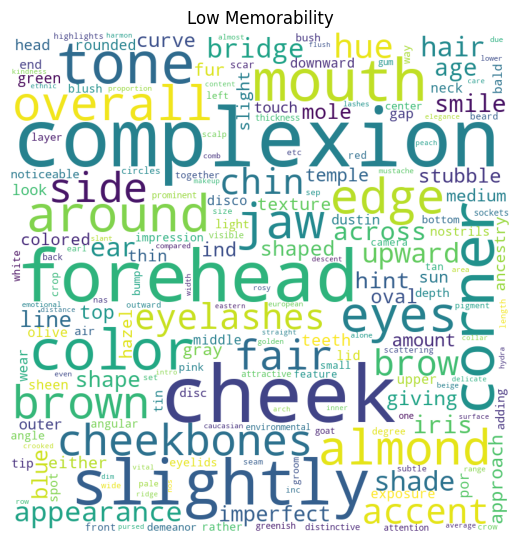

In [193]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(' '.join([l.strip().lower() for l in low_mem_words if len(l)>2 and l not in ['skin','lip','eyebrow','nose', 'eyebrows','face', 'facial','eye','lips']]))
                       
plt.figure(figsize = (5, 5), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Low Memorability')
plt.show()

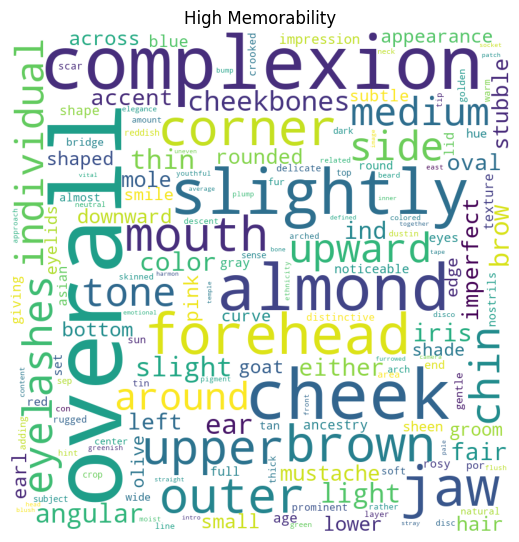

In [194]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(' '.join([l.strip().lower() for l in high_mem_words if len(l)>2 and l not in ['skin','lip','eyebrow','nose', 'eyebrows','face', 'facial','eye','lips']]))
                       
plt.figure(figsize = (5, 5), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('High Memorability')
plt.show()

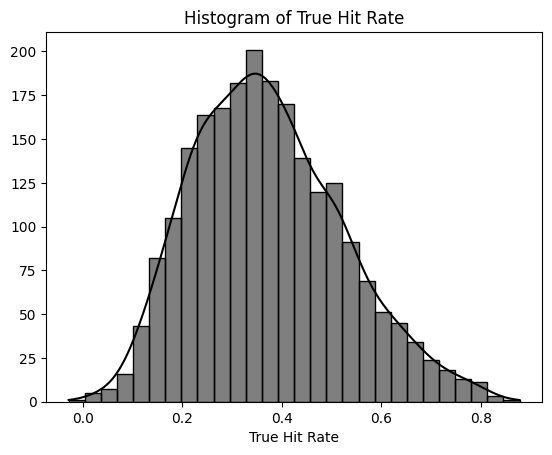

In [27]:
sns.histplot(face.thr, kde=True, color='black')
plt.xlabel('True Hit Rate')
plt.ylabel('')
plt.title('Histogram of True Hit Rate');

In [ ]:
plt.gcf().set_size_inches(12,6)

plt.subplot(1,3,1)
plt.imshow(plt.imread(f"{path}\\{face[face.thr<0.3].sample(1).image_id.values[0]}"))
plt.axis(False)
plt.title('Low Memorability')

plt.subplot(1,3,2)
plt.imshow(plt.imread(f"{path}\\{face[(face.thr>=0.3) & (face.thr<0.6)].sample(1).image_id.values[0]}"))
plt.axis(False)
plt.title('Medium Memorability')

plt.subplot(1,3,3)
plt.imshow(plt.imread(f"{path}\\{face[face.thr>=0.6].sample(1).image_id.values[0]}"))
plt.axis(False)
plt.title('High Memorability');